In [3]:
from spectral_cube import SpectralCube #To read FITS
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from skimage import measure
from astropy import wcs
import cube_x3d as c3
import matplotlib.pyplot as plt
from matplotlib import cm
from astroquery.skyview import SkyView

In [65]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [4]:
%cd C:\Users\ixaka\Documents\Visualization

C:\Users\ixaka\Documents\Visualization


In [5]:
# Read the fits file and save header
HI_cube = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_HRR_final_rss.fits')
cubehead = HI_cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = HI_cube.shape
print(HI_cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv))

(4300, 52, 58)


(0.0, 4e-16)

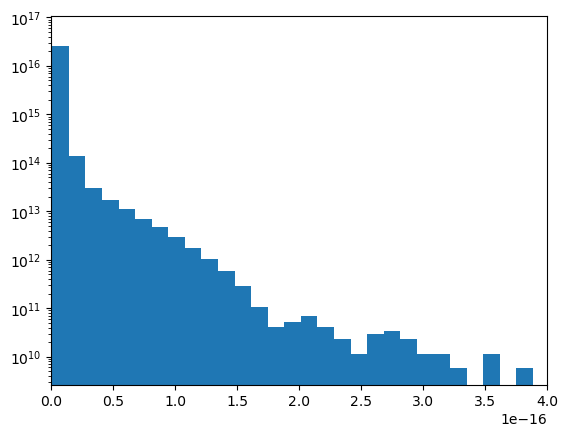

In [8]:
plt.hist(HI_cube.unmasked_data[:].to_value().flatten(), bins=400, density=True)
plt.yscale('log')
plt.xlim(0,4e-16)

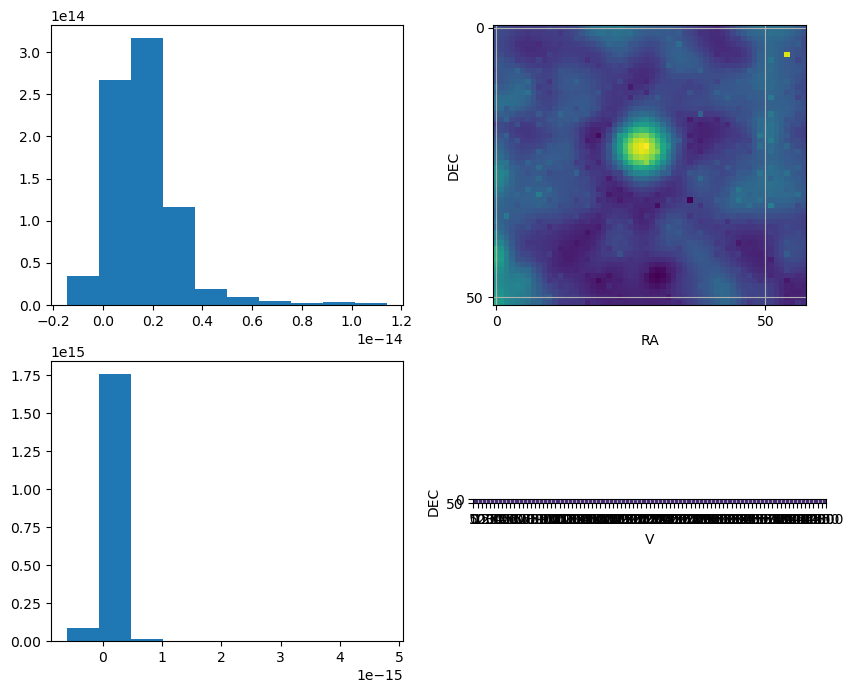

In [13]:
c3.preview2d(HI_cube.unmasked_data[:].to_value())

In [14]:
limx = [0, nx-1]
limy = [0, ny-1]
limz = [0, nz-1]

In [26]:
#borja MRB
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
limz = [3450, nz-111]

In [6]:
#borja HRR
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
limz = [1520, 2100-1] #also 4300-2200

In [7]:
ralim = HI_cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = HI_cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = HI_cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('nm').to_value()

In [8]:
def transpose(array, delta):
    dra, ddec, dv = delta
    return np.transpose(array, (2,1,0))[::int(np.sign(dra)), ::int(np.sign(ddec)),::int(np.sign(dv))]

In [9]:
# create cropped array and transform units to mJy/beam
HI_cube = HI_cube.unmasked_data[limz[0]:limz[1]+1,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value() *10**17 #*10**16 for MRB
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = transpose(HI_cube, (dra,ddec,dv))

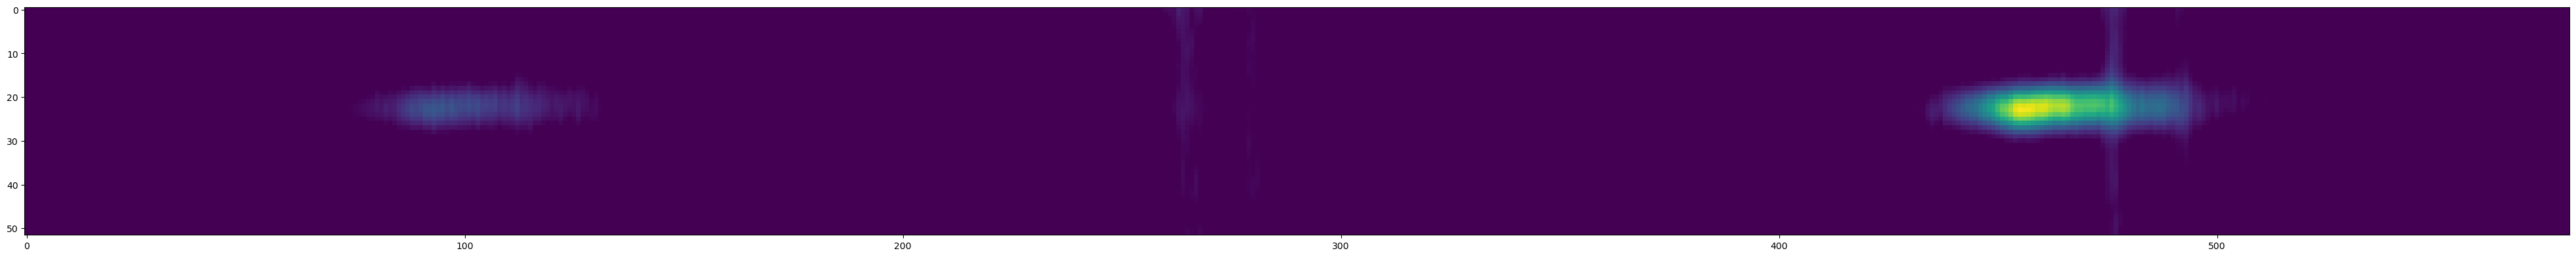

In [190]:
fig, ax = plt.subplots(figsize=(50,20))
ax.imshow(HI_cube[29,:,:], vmin=1, vmax=14)
#ax.set_xlim(1500,2100)

In [30]:
#MRB
cube1 = np.empty(HI_cube.shape)
cube1[:,:,20:180] = HI_cube[:,:,20:180]
cube2 = np.empty(HI_cube.shape)
cube2[:,:,500:600] = HI_cube[:,:,500:600]

In [10]:
#HRR
cube1 = np.empty(HI_cube.shape)
cube1[:,:,:200] = HI_cube[:,:,:200]
cube2 = np.empty(HI_cube.shape)
cube2[:,:,200:350] = HI_cube[:,:,200:350]
cube3 = np.empty(HI_cube.shape)
cube3[:,:,350:] = HI_cube[:,:,350:]

(0.0, 18.0)

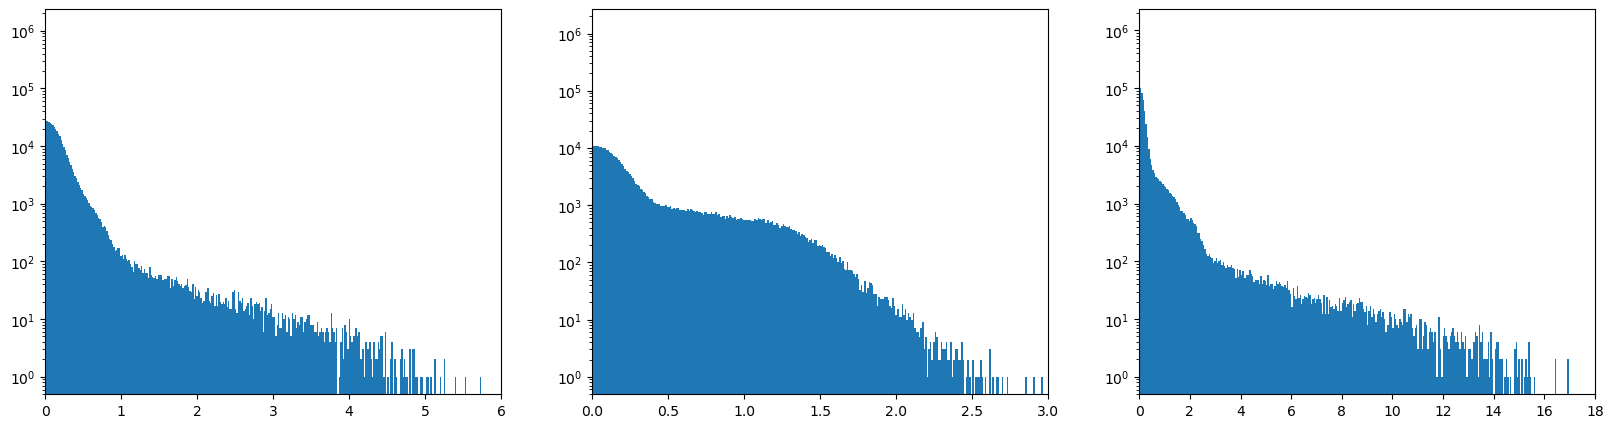

In [183]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].hist(cube1.flatten(), bins=400)
ax[0].set_yscale('log')
ax[0].set_xlim(0,6)
ax[1].hist(cube2.flatten(), bins=400)
ax[1].set_yscale('log')
ax[1].set_xlim(0,3)
ax[2].hist(cube3.flatten(), bins=400)
ax[2].set_yscale('log')
ax[2].set_xlim(0,18)

In [31]:
#MRB
isolevels1 = np.array([0.45, 1.1, 2.3, 4, 6])
isolevels2 = np.array([0.41, 1.1, 2, 5, 9, 13, 18])
isolevels = [isolevels1, isolevels2]


In [11]:
#HRR
isolevels1 = np.array([0.7, 1.2, 2, 2.8, 3.5])
isolevels2 = np.array([0.4, 0.7, 1.2, 2])
isolevels3 = np.array([1.2, 2.5, 4.5, 6.5, 8.5, 10.5])
isolevels = [isolevels1, isolevels2, isolevels3]

In [12]:
# Save new dimensions
nx_2, ny_2, nz_2 = HI_cube.shape
print(HI_cube.shape)

(58, 52, 580)


In [13]:
coords = np.array([ralim, declim, vlim])

In [14]:
color1 = c3.create_colormap('Blues', isolevels1)
color2 = c3.create_colormap('Reds', isolevels2)
color3 = c3.create_colormap('Greens', isolevels3)
colors = [color1,color2,color3]

In [15]:
meta = {'generator':'create_x3d python module',
       'creator':'Name Surname',
       'title':cubehead['OBJECT'],
        'numberofelements':f'{len(isolevels)} layers',
        'description':'HI data cube of %s'%cubehead['OBJECT']
       }

In [16]:
x3dname = 'borja_hrr.x3d'

In [17]:
file = c3.write_x3d('./cube_x3d/examples/%s'%x3dname, delta_arcsec,
                    coords, header=cubehead, units=["e17 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'], meta=meta, picking=False)

#also need html.func_pick() if picking=True

[[ -6.10790397   0.           6.10790397]
 [ -5.4672       0.           5.4672    ]
 [-28.1973       0.          28.1973    ]]


In [18]:
file.make_layers([cube1,cube2,cube3], isolevels, colors)
file.make_outline()
#file.make_galaxies(gals=gals, labels=True)
file.make_image2d(imcol=None, img_shape=None)
file.make_ticklines()
file.make_labels(gals=None, axlab='both') 
#html.func_scalev(axes) should be same as axlab, not func_axes() though.
file.close()

In [19]:
tabtitle = 'optical'
pagetitle = 'optical interactive datacube with X3D'
# add in desc for 2d image: <br>\n\t Background image: {survey}
#desc = f"Object: {cubehead['OBJECT']}.<t> Telescope: {cubehead['TELESCOP']}. RestFreq = {cubehead['RESTFREQ']/1e6:.4f} MHz.<br>\n\t Center: (RA,Dec,V)=({np.round(ramean,5)}, {np.round(decmean,5)}, {np.round(vmean,3)} km/s)"

In [20]:
colmaps = ['magma', 'CMRmap', 'inferno', 'plasma', 'viridis', 'Greys',
           'Blues', 'OrRd', 'PuRd', 'Reds', 'Spectral', 'Wistia',
          'YlGn', 'YlOrRd', 'afmhot', 'autumn', 'cool', 'coolwarm',
          'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_heat',
          'gist_ncar', 'gist_stern', 'gnuplot', 'gnuplot2', 'hot',
          'nipy_spectral', 'prism', 'winter', 'Paired']

In [43]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [21]:
html = c3.write_html('./cube_x3d/examples/%s.html'%x3dname.split('.')[0], 
                    units=["e17 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'],
                     tabtitle=tabtitle, pagetitle=pagetitle,
                     description=None)

In [22]:
file.diff_coords

array([[ -6.10790397,   0.        ,   6.10790397],
       [ -5.4672    ,   0.        ,   5.4672    ],
       [-28.1973    ,   0.        ,  28.1973    ]])

In [204]:
html.func_layers([len(isolevels1), len(isolevels2), len(isolevels3)])
#html.func_galaxies(gals)
#html.func_gallab()
html.func_grids()
html.func_axes('both')
#html.func_pick() #for coordinate picking
html.start_x3d()
html.viewpoints(maxcoord=file.diff_coords[:,2])
html.close_x3d(x3dname)
html.buttons(isolevels, colormaps=colmaps, hide2d=True, scalev=True, move2d=True, centRotLabs=True)
#func_move2dimage, func_setCenterOfRotation, func_colormaps and func_scalev must always go after buttons
html.func_image2d()
html.func_setCenterOfRotation(['0 0 -19', '0 0 -4','0 0 17.5']) #['0 0 -29.3', '0 0 19.1'] for MRB
html.func_colormaps(isolevels)
html.func_scalev(gals=None, axes='both', coords=file.diff_coords, vmax=file.diff_coords[2,2]) #file.diff_coords[2,2]
html.func_move2dimage(real_vmax=file.real_coords[2,2], diff_vmax=file.diff_coords[2,2])
html.close_html()